In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from aesara import shared as tshared
import aesara.tensor as tt
from aesara import function, printing
import arviz as az

# Random seed
np.random.seed(713)

In [2]:
import matplotlib

%matplotlib inline
matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

matplotlib.rcParams['figure.dpi']= 150

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

In [16]:
# (HF budget, HF mean errors)
data = np.loadtxt("../budget_size/hfonly_budget_size.txt").T

In [17]:
x_train = data[:, [0]]
y_train = data[:, [1]]
y_sigma = data[:, [2]]

# dimensionality of the emulator
d = 5

The parametric model is

$$
\mathrm{error} = \theta \cdot n_\mathrm{HF}^{- \nu / d}
$$

In [78]:
with pm.Model() as budget_model:
    theta = pm.Normal("theta", mu=y_train.mean(), sigma=y_train.std() * 10)

    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu1 = pm.Uniform("nu1", 1e-6, 15)

    y = theta * (x_train[:, 0] ** (- nu1 / d)) 

    pm.Normal("likelihood", mu=y, sigma=y_sigma[:, 0], observed=y_train[:, 0])

In [79]:
with budget_model:
    trace = pm.sample(10000, tune=35000, )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, nu1]


Sampling 4 chains for 35_000 tune and 10_000 draw iterations (140_000 + 40_000 draws total) took 24 seconds.
There were 673 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
There were 451 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6584, but should be close to 0.8. Try to increase the number of tuning steps.


In [80]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

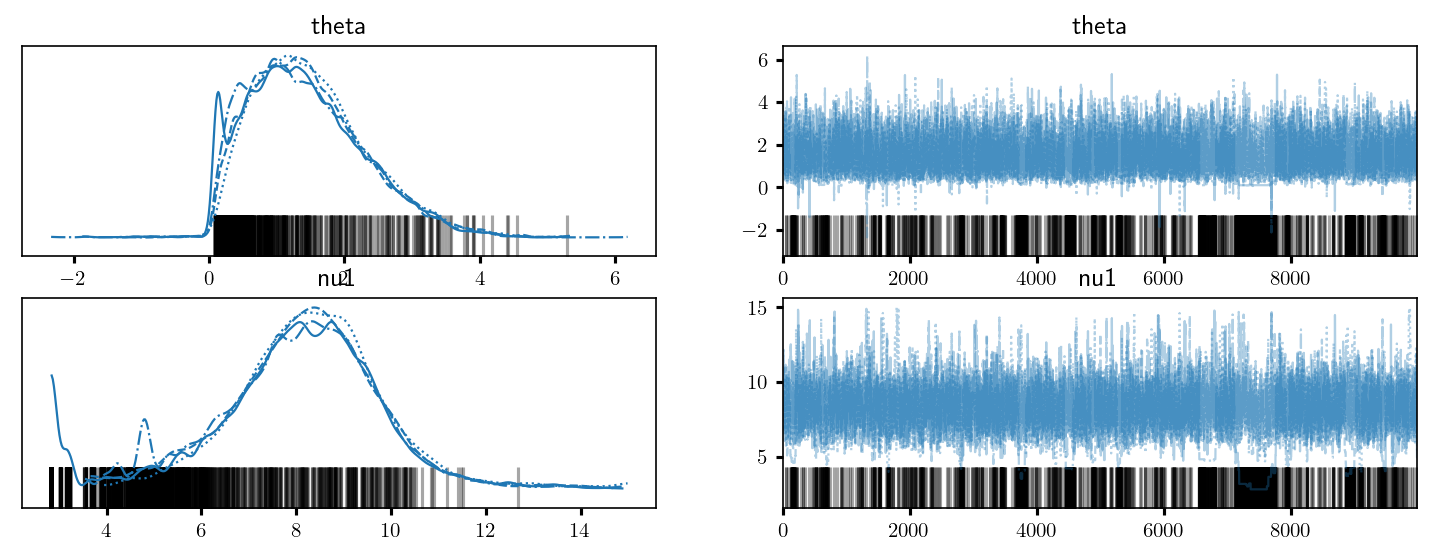

In [81]:
# plotting setting to make the arviz plots look less buggy
# az.style.use("arviz-darkgrid")

with budget_model:
    rvs = ["theta", "nu1", ]

    _ = az.plot_trace(trace, var_names=rvs)
    
# plt.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_mcmc_chains.pdf", bbox_inches='tight', pad_inches=0.075)

In [82]:
n_hf = x_train[:, 0]

y_true = y_train[:, 0]

theta_mode = np.median(trace.posterior["theta"])
nu_mode    = np.median(trace.posterior["nu1"])

theta_lower, theta_mode, theta_upper = np.quantile(trace.posterior["theta"], [0.25, 0.5, 0.75])
nu_lower, nu_mode, nu_upper       = np.quantile(trace.posterior["nu1"], [0.25, 0.5, 0.75])

y_pred = theta_mode * (
    n_hf ** (- nu_mode / d )
)

y_pred_lower = theta_lower * (
    n_hf ** (- nu_upper / d )
)

y_pred_upper = theta_upper * (
    n_hf ** (- nu_lower / d )
)

print(nu_mode, theta_mode)

8.220734295334548 1.3453783546862548


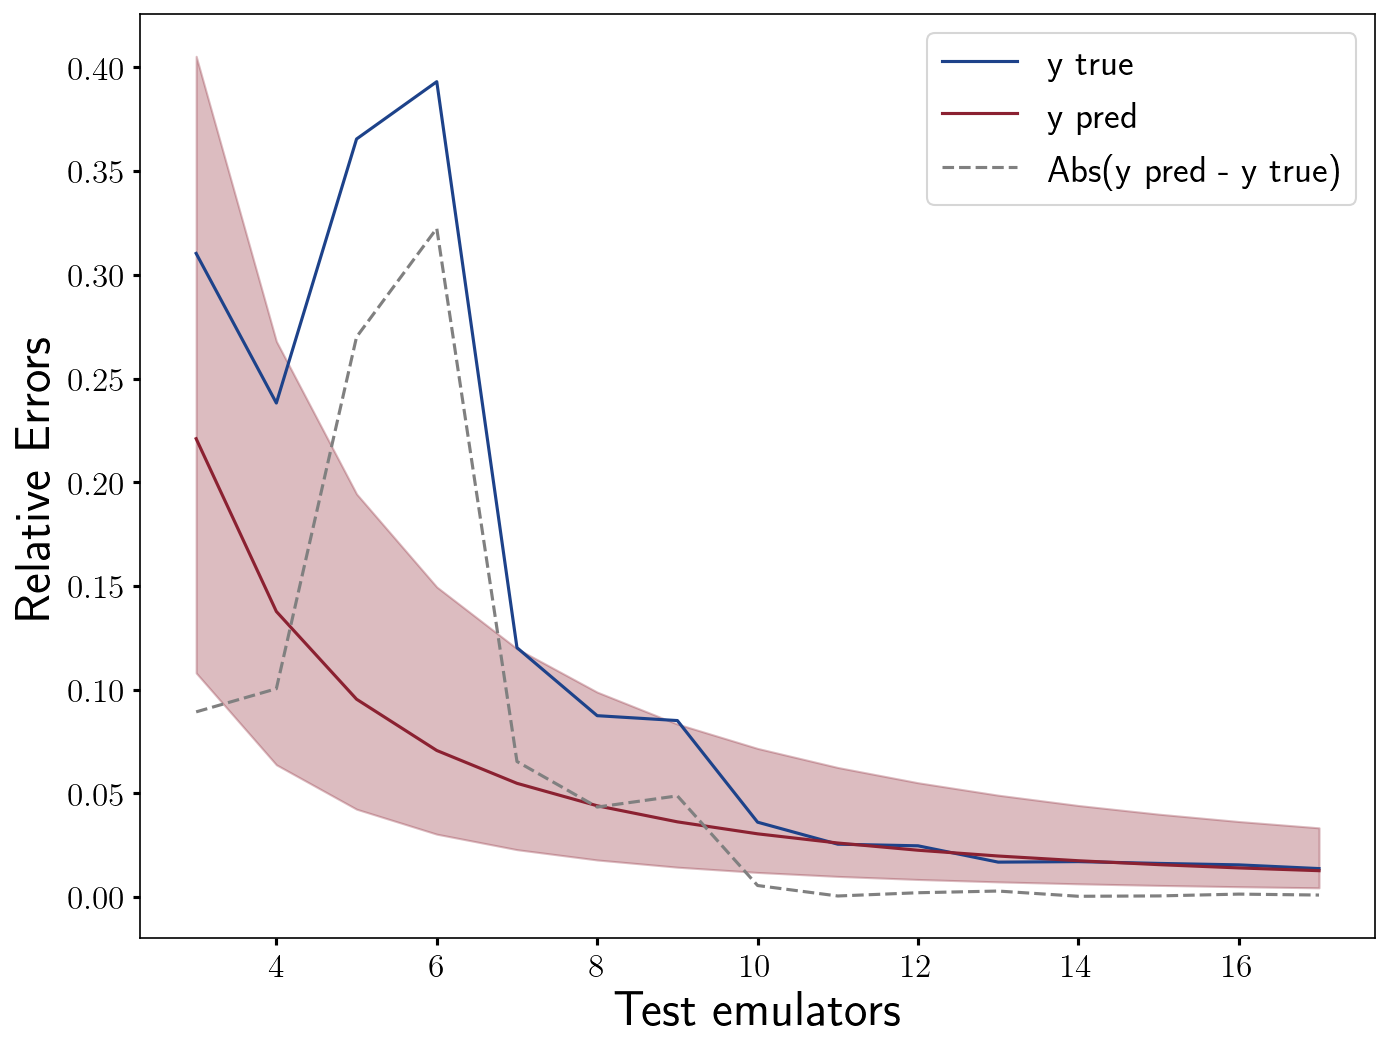

In [83]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

plt.plot(n_hf, y_true, label=r"y true", color=colors[2])
plt.plot(n_hf, y_pred, label=r"y pred", color=colors[0])

plt.fill_between(n_hf, y1=y_pred_lower, y2=y_pred_upper, alpha=0.3, color=colors[0])

plt.plot(n_hf, np.abs(y_pred - y_true), ls="--", color="grey", label=r"Abs(y pred - y true)" )

# plt.ylim((0.0, 0.05))
plt.ylabel("Relative Errors")
plt.xlabel("Test emulators")
plt.legend()

# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_all_test_errors.pdf", bbox_inches='tight', pad_inches=0.075)



In [85]:
theta_mode * (
    np.array([20, 40, 60]) ** (- nu_mode / d )
)

array([0.00976697, 0.0031248 , 0.00160436])